In [1]:
# Standard library imports
import time
import os
import glob
import shutil

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from osgeo import gdal
from scipy import interpolate
from scipy.ndimage import generic_filter
import pandas as pd
import geopandas as gpd
import pyproj
import rasterio
from rasterio.features import rasterize
import shapefile as shp
import vtk
from shapely.geometry import Point
from scipy.spatial import distance
import pyvista as pv

# Flopy imports
import flopy
from flopy.mf6.utils.reference import SpatialReference
from flopy.utils import Raster, CellBudgetFile, HeadFile, binaryfile as bf
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
from flopy.discretization import StructuredGrid
from flopy.modflow import ModflowStr, ModflowRch, ModflowNwt
from flopy.utils.zonbud import ZoneBudget
from flopy.mf6 import MFSimulation
from flopy.mf6.modflow import ModflowGwfrcha, ModflowGwfsfr, ModflowGwfriv
from flopy.utils import ZoneBudget6

# Code purpose: import modules for a Python script
print("Modules imported successfully.")

c:\Users\sebas\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\sebas\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\sebas\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Modules imported successfully.


# Be careful when deleting the directory!

In [2]:
# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe','Gondebeek_ini.hds','*.ntb','*.in','*.smp','*.dat','*.png','*.fig','*.bat']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

In [3]:
print(flopy.__version__)

3.6.0


Customized functions are integrated in the mod_utils.py library

In [4]:
import mod_utils
import importlib
importlib.reload(mod_utils)

<module 'mod_utils' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow\\mod_utils.py'>

Geometry input data

In [5]:
# Geometry
geometry_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Marylidia_data\\DEM\\DEM"
shp_Gondebeek_path = os.path.join(geometry_path,"Catchment_Gondebeek_v2.shp")
raster_DEM_path= os.path.join(geometry_path,'DEM_Gondebeek.asc')
raster_A100t_path = os.path.join(geometry_path,'A0100_t.asc')
raster_Paniseliaan_Brusseliaan_Aquifer_path=os.path.join(geometry_path,'A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc')
raster_Paniseliaan_Aquitard_path= os.path.join(geometry_path,'A0700_Paniseliaan_Aquitard.asc')    
raster_eperiaan_Aquifer_path= os.path.join(geometry_path,'A0800_Leperiaan_Aquifer.asc')    

The main working directory and model directory are defined

In [6]:
modelname = 'Gondebeek'
model_dir = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow"

General geometrical aspects of the model are defined

In [7]:
# Load shape
shp_obj = shp.Reader(shp_Gondebeek_path)

# Read shape
feature = shp_obj.shapeRecords()[0]

# Domain extension
bbox = feature.shape.bbox
Lx = -(bbox[0]-bbox[2]) #m
Ly = -(bbox[1]-bbox[3]) #m

# Horizontal discretization
delr = 100
delc = 100

# Number of model rows, and cols
nrow = Ly / delr
ncol = Lx / delc

# Actualizar nrow y ncol
nrow = int(np.round(nrow+.5))
ncol = int(np.round(ncol+.5))

# Actualizar Lx y Ly
Ly = nrow*delr
Lx = ncol*delc

# Origins round to left and up
xul = int(bbox[0]//100*100)
yul = int((bbox[3])//100*100+100)

# Number of layers between guide layers
gls_lays = np.array([1,1,1,1])

# Total N of layers are calculated
nlay = gls_lays.sum()

Guide layer elevations are loaded and interpolated to the model grid, including top later DEM

This Python function, ```interpolate_to_grid```, is designed to interpolate data from a set of files to a model grid using the natural neighbor method:

1. **Function Signature:**
    `interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc, base_layer=None, skiprows=None)`

2. **Parameters:**
    - `file_list`: A list of input files.
    - `xul`, `yul`: The upper left coordinates of the model grid.
    - `nrow`, `ncol`: The number of rows and columns in the model grid.
    - `delr`, `delc`: The row and column spacing in the model grid.
    - `base_layer`: An optional layer that defines the base of the model.
    - `skiprows`: The number of rows to skip in the file.

3. **Process:**
    - The function first generates a model grid of (x, y) coordinates.
    - It then initializes an array to hold the interpolated data.
    - If a base layer is provided, it is added to the interpolated array.
    - The function then loops over each file in the file list.
        - It opens each file and reads its lines.
        - It gathers the characteristics of the asc file from the first 6 lines.
        - It loads the data from the asc file into a grid.
        - It generates a grid of (x, y) coordinates for the asc file.
        - It uses the `griddata` function from the `scipy.interpolate` module to interpolate the data from the asc grid to the model grid.
        - It then loops over each cell in the model grid, checking if the interpolated data is less than or equal to 0. If it is, it sets the cell value to the value from the previous layer minus 1. Otherwise, it sets the cell value to the interpolated data.

4. **Return:**
    - The function returns a 3D array with the interpolated data.

In [8]:
file_list = [raster_DEM_path,raster_A100t_path,raster_Paniseliaan_Brusseliaan_Aquifer_path,raster_Paniseliaan_Aquitard_path,raster_eperiaan_Aquifer_path]

interp_elevs = mod_utils.interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc)



In [9]:
interp_elevs[1]

array([[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       ...,
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]],
      dtype=float32)

Guide layer elevations are corrected so they do not cross between each other

1. **Function Signature:**
    `check_layer_elevs(elev_array, threshold=None)`

2. **Parameters:**
    - `elev_array`: A 3D array containing the layer elevation information.
    - `threshold`: An optional parameter that specifies the elevation difference to be assigned if an overlapping layer is encountered. The default value is 0.1.

3. **Process:**
    - The function first checks if a threshold is provided. If not, it sets the threshold to 0.1.
    - It then gets the dimensions of the 3D array.
    - The function loops over each layer in the array (except the first one), and for each cell in each layer, it calculates the difference in elevation between the current layer and the one above it.
    - If the difference is less than or equal to 0 (indicating an overlap), it adjusts the elevation of the current cell to be lower than the cell above it by the specified threshold.

4. **Return:**
    - The function returns the adjusted 3D array.

In [10]:
interp_elevs = mod_utils.check_layer_elevs(interp_elevs,1.01)
len(gls_lays)
len(interp_elevs)

5

Botm and topm array are generated

In [11]:
botm = np.zeros((nlay,nrow,ncol),dtype=float)
botm = mod_utils.fill_botm_array(botm,interp_elevs,gls_lays)
topm = mod_utils.fill_topm_array(botm,interp_elevs,gls_lays)


In [12]:
top=topm[0]
top

array([[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       ...,
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]])

Temporal discretization

In [13]:
# Fecha inicial y final
year_0 = 2012; month_0 = 1; day_0 = 1 
year_F = 2019; month_F = 1; day_F = 1 

SP = mod_utils.Constru_SP(year_0, month_0, day_0, year_F, month_F, day_F, scale='d', n_scale=1)
perlen, fecha_inicialSP, fecha_finalSP, nstp, tsmult, steady = SP
nper = len(perlen)


Basic packages are created

In [14]:
# Path to MODFLOW 6 executable
mf6_exe = os.path.join('mf6')

# Create the simulation object
sim = flopy.mf6.MFSimulation(sim_name=modelname, version='mf6', exe_name=mf6_exe, sim_ws=model_dir)

# Create the groundwater flow model object
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True,newtonoptions="UNDER_RELAXATION")

#Create the ATS package
ats = flopy.mf6.modflow.mfutlats.ModflowUtlats(
    parent_package=sim, 
    maxats=len(perlen), 
    perioddata=[(i, 1.0, 1e-5, 100.0, 2.0, 5.0) for i in range(nper)]
)
ats.write()

# Create the time discretization object with 1 time step per stress period
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS', nper=nper, perioddata=[(perlen[i], nstp[i], tsmult[i]) for i in range(nper)], ats_perioddata=[(i, 1, 1e-5, 100.0, 2.0, 5.0) for i in range(nper)])

#Create the iterative model solver object
ims = flopy.mf6.ModflowIms(
    sim,
    print_option='SUMMARY',
    outer_dvclose=1e-4,
    outer_maximum=600,
    under_relaxation='DBD',
    under_relaxation_gamma          = 0.01,
    under_relaxation_theta          = 0.8,
    under_relaxation_kappa          = 0.1,
    under_relaxation_momentum       = 0.0,
    backtracking_number             = 200,
    backtracking_tolerance          = 1.5, 
    backtracking_reduction_factor   = 0.9,
    backtracking_residual_limit     = 1,
    inner_maximum=600,
    inner_dvclose=1e-4,
    rcloserecord=[1e-5, 'RELATIVE_RCLOSE'],
    linear_acceleration='BICGSTAB',
    relaxation_factor=0.97,
    preconditioner_levels=7,
    preconditioner_drop_tolerance=1e-4,
    number_orthogonalizations=10,
    scaling_method='NONE',
    reordering_method='NONE',
)

# Get the initial botm and top arrays
botm_array = botm.copy()
top_array = interp_elevs[0].copy()

# Create a mask where botm and top are not -1.000000E+09
mask = np.logical_and(botm_array != -1.000000E+09, top_array != -1.000000E+09)

# Create an IBOUND array based on the mask
ibound = np.where(mask, 1, 0)

# Change -1e9 to zero
botm_array[botm_array == -1.000000E+09] = 0
top_array[top_array == -1.000000E+09] = 0

# Define the lower-left y-coordinate
yll = 177000.0

# Calculate the total height of the model grid
total_height = nrow * delc

# Adjust the y-origin
yul = yll + total_height

# Create the discretization package
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top_array, botm=botm_array, xorigin=xul, yorigin=yll, idomain=ibound)


# Path to the .hds file
hds_file = "C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_it8/Gondebeek_SS.hds"

# Read the head data from the .hds file
headobj = HeadFile(hds_file)
head = headobj.get_data()

# Create the initial conditions package with the head data from the previous run
ic = flopy.mf6.ModflowGwfic(gwf, strt=head)

# Create the node property flow package
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1, k=500)

# Get the number of stress periods
nper = sim.tdis.nper.data


# Create a dictionary of save records
saverecord = {i: [('HEAD', 'LAST'), ('BUDGET', 'LAST')] for i in range(nper)}

# Create the output control package
oc = flopy.mf6.ModflowGwfoc(
    gwf, 
    pname='oc', 
    budget_filerecord='Gondebeek.cbc', 
    head_filerecord='Gondebeek.hds', 
    saverecord=saverecord
)
# Write the simulation to disk
sim.write_simulation()








writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package Gondebeek.ats...
  writing package Gondebeek.tdis.ats...
  writing model Gondebeek...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...


In [15]:

def update_maxats(file_path, maxats_value):
    # Check if the file exists
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Find the line containing 'MAXATS' and update it
    for i, line in enumerate(lines):
        if "MAXATS" in line:
            parts = line.split()
            parts[1] = str(maxats_value)
            lines[i] = ' '.join(parts) + '\n'
            break

    # Write the updated contents back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# Replace 'your_file_path' with the path to your Gondebeek.tdis.ats file
# Replace 'your_maxats_value' with the numeric value of nper
update_maxats('Gondebeek.tdis.ats', nper)

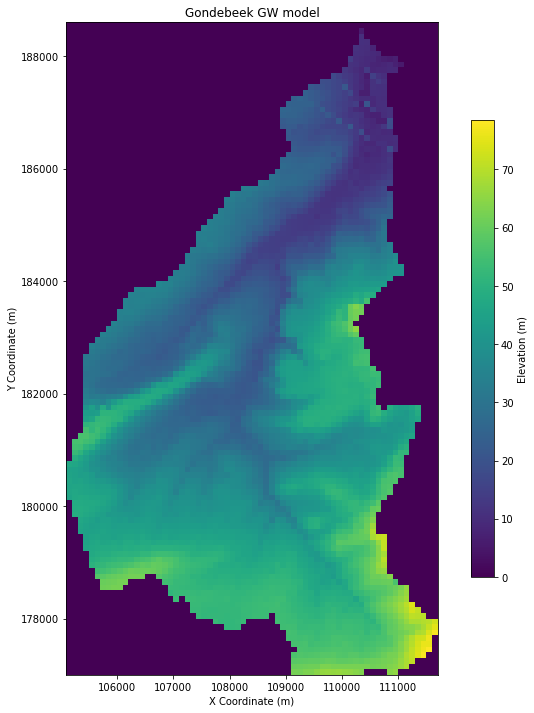

In [16]:

# Get the top layer of the model
top_layer = gwf.dis.top.array

# Define the minimum and maximum values for the colorbar
vmin, vmax = 0, top_layer.max()

# Create a figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a map of the model
modelmap = flopy.plot.PlotMapView(model=gwf)

# Plot the top layer of the model
quadmesh = modelmap.plot_array(top_layer, vmin=vmin, vmax=vmax)

# Plot the grid and inactive cells
#linecollection = modelmap.plot_grid()
#quadmesh = modelmap.plot_ibound(ibound=noflow, color_noflow='cyan')

# Add a colorbar with a label
cbar = plt.colorbar(quadmesh, shrink=0.7)
cbar.set_label('Elevation (m)')

# Add labels to the x and y axes
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')

# Add a title
plt.title("Gondebeek GW model")

# Save the plot as a PNG file
plt.savefig('Gondebeek_GW_model.png')

# Show the plot
plt.show()

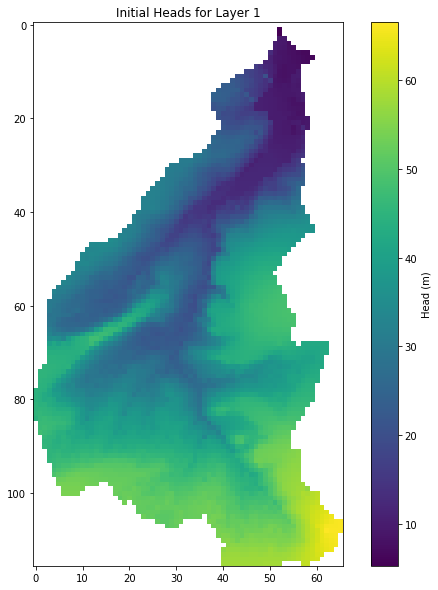

In [17]:
import matplotlib.pyplot as plt

# Get the IC package
ic = gwf.get_package('ic')

# Get the initial heads
initial_heads = ic.strt.array

# Mask values lower than -900
initial_heads = np.ma.masked_where(initial_heads > 900, initial_heads)

# Plot the initial heads for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(initial_heads[0, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Initial Heads for Layer 1')
plt.show()

### Copying hydraulic properties from final SS model

In [18]:
# Check if 'sim' and 'gwf' are already defined
if 'sim' not in globals() or 'gwf' not in globals():
    # Load the model
    sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek')
    gwf = sim.get_model('Gondebeek')


# Path to the source model
source_model_dir = "C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_it8"

# Load the source model
source_sim = MFSimulation.load(sim_name='Gondebeek_SS', sim_ws=source_model_dir, exe_name='mf6')
source_gwf = source_sim.get_model('Gondebeek_SS')

# Get the NPF and STO packages from the source model
source_npf = source_gwf.get_package('npf')
source_sto = source_gwf.get_package('sto')

# Remove the existing NPF and STO packages from the current model
gwf.remove_package('npf')
gwf.remove_package('sto')

# Create new NPF and STO packages for the current model using the parameters from the source model
npf = flopy.mf6.ModflowGwfnpf(gwf, pname='npf', save_flows=source_npf.save_flows, 
                              icelltype=[1,0,0,0], k=source_npf.k.array)
sto = flopy.mf6.ModflowGwfsto(gwf, pname='sto', save_flows=source_sto.save_flows, 
                              iconvert=[1,0,0,0], ss=source_sto.ss.array, sy=source_sto.sy.array, transient=True) #only first layer should be convertible

# Write the simulation to disk
sim.write_simulation()
update_maxats('Gondebeek.tdis.ats', 2557)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package Gondebeek.ats...
  writing package Gondebeek.tdis.ats...
  writing model Gondebeek...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...


In [19]:

help(flopy.mf6.ModflowGwfnpf)

Help on class ModflowGwfnpf in module flopy.mf6.modflow.mfgwfnpf:

class ModflowGwfnpf(flopy.mf6.mfpackage.MFPackage)
 |  ModflowGwfnpf(model, loading_package=False, save_flows=None, print_flows=None, alternative_cell_averaging=None, thickstrt=None, cvoptions=None, perched=None, rewet_record=None, xt3doptions=None, save_specific_discharge=None, save_saturation=None, k22overk=None, k33overk=None, perioddata=None, dev_no_newton=None, dev_modflowusg_upstream_weighted_saturation=None, dev_modflownwt_upstream_weighting=None, dev_minimum_saturated_thickness=None, dev_omega=None, icelltype=0, k=1.0, k22=None, k33=None, angle1=None, angle2=None, angle3=None, wetdry=None, filename=None, pname=None, **kwargs)
 |  
 |  ModflowGwfnpf defines a npf package within a gwf6 model.
 |  
 |  Parameters
 |  ----------
 |  model : MFModel
 |      Model that this package is a part of. Package is automatically
 |      added to model when it is initialized.
 |  loading_package : bool
 |      Do not set this p

Export hk to SHP for comparison with input data

In [20]:
# Set the layer index
layer_index = 0

# Retrieve the hydraulic conductivity array for the desired layer
hk_array = gwf.npf.k.array[layer_index]

# Set inactive cells to NaN
ibound = gwf.dis.idomain.array
noflow=ibound
active_cells = ibound > 0
hk_layer = hk_array[noflow[layer_index]>0]

# Define the coordinate reference system
crs1 = pyproj.CRS("EPSG:31370")

fname="hk.shp"
gwf.npf.k.export(fname,crs=crs1,write_prj="31370.prj")

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


In [21]:
import mod_utils
import importlib
importlib.reload(mod_utils)

<module 'mod_utils' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow\\mod_utils.py'>

In [22]:
gwf.npf.check()


npf PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0



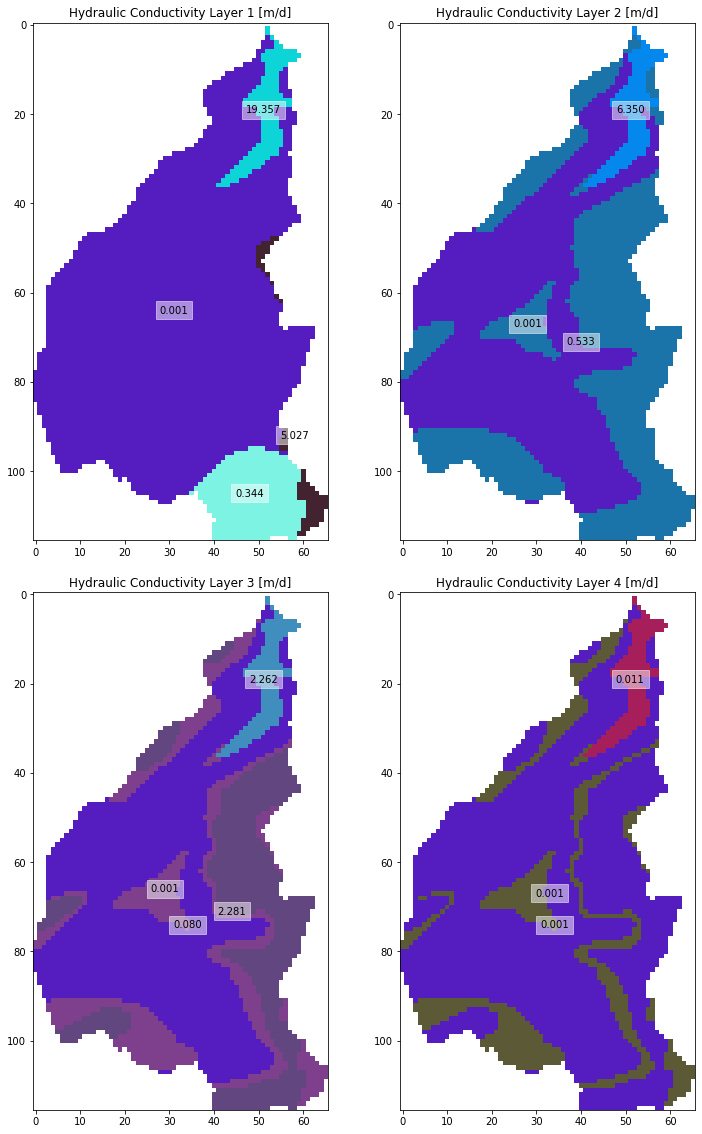

In [23]:
# Get the hydraulic conductivity values
hk = gwf.npf.k.array

# Get the idomain values
idomain = gwf.dis.idomain.array

# Mask the hydraulic conductivity values with the idomain
hk_masked = np.ma.masked_where(idomain == 0, hk)

# Get unique hydraulic conductivity values and assign each a unique random color
unique_hk = np.unique(hk_masked.compressed())  # Use the compressed() method to remove the MaskedConstant values
colors = [np.random.rand(3,) for _ in range(len(unique_hk))]
hk_color_dict = dict(zip(unique_hk, colors))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=-0.51, hspace=0.1)

# Plot the hydraulic conductivity of each layer
for i, layer in enumerate(hk_masked):
    ax = axs[i//2, i%2]  # Select the current subplot
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))  # Initialize the color_layer array with ones
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                color_layer[j, k] = hk_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    
    ax.set_title(f'Hydraulic Conductivity Layer {i+1} [m/d]')
    
    # Create a dictionary where each unique hydraulic conductivity value is a key and the corresponding value is a list of coordinates where this hydraulic conductivity value occurs
    hk_coords = {hk: [] for hk in unique_hk}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                hk_coords[layer[j, k]].append((j, k))
    
    # For each unique hydraulic conductivity value, calculate the center of the corresponding coordinates and display the hydraulic conductivity value at this center
    for hk, coords in hk_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1], center[0], f'{hk:.3f}', ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use three significant digits


# Create the filename by adding the string "flooded_cells"
filename = "initial_HK_layers.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename)

# Show the figure (optional)
plt.show()

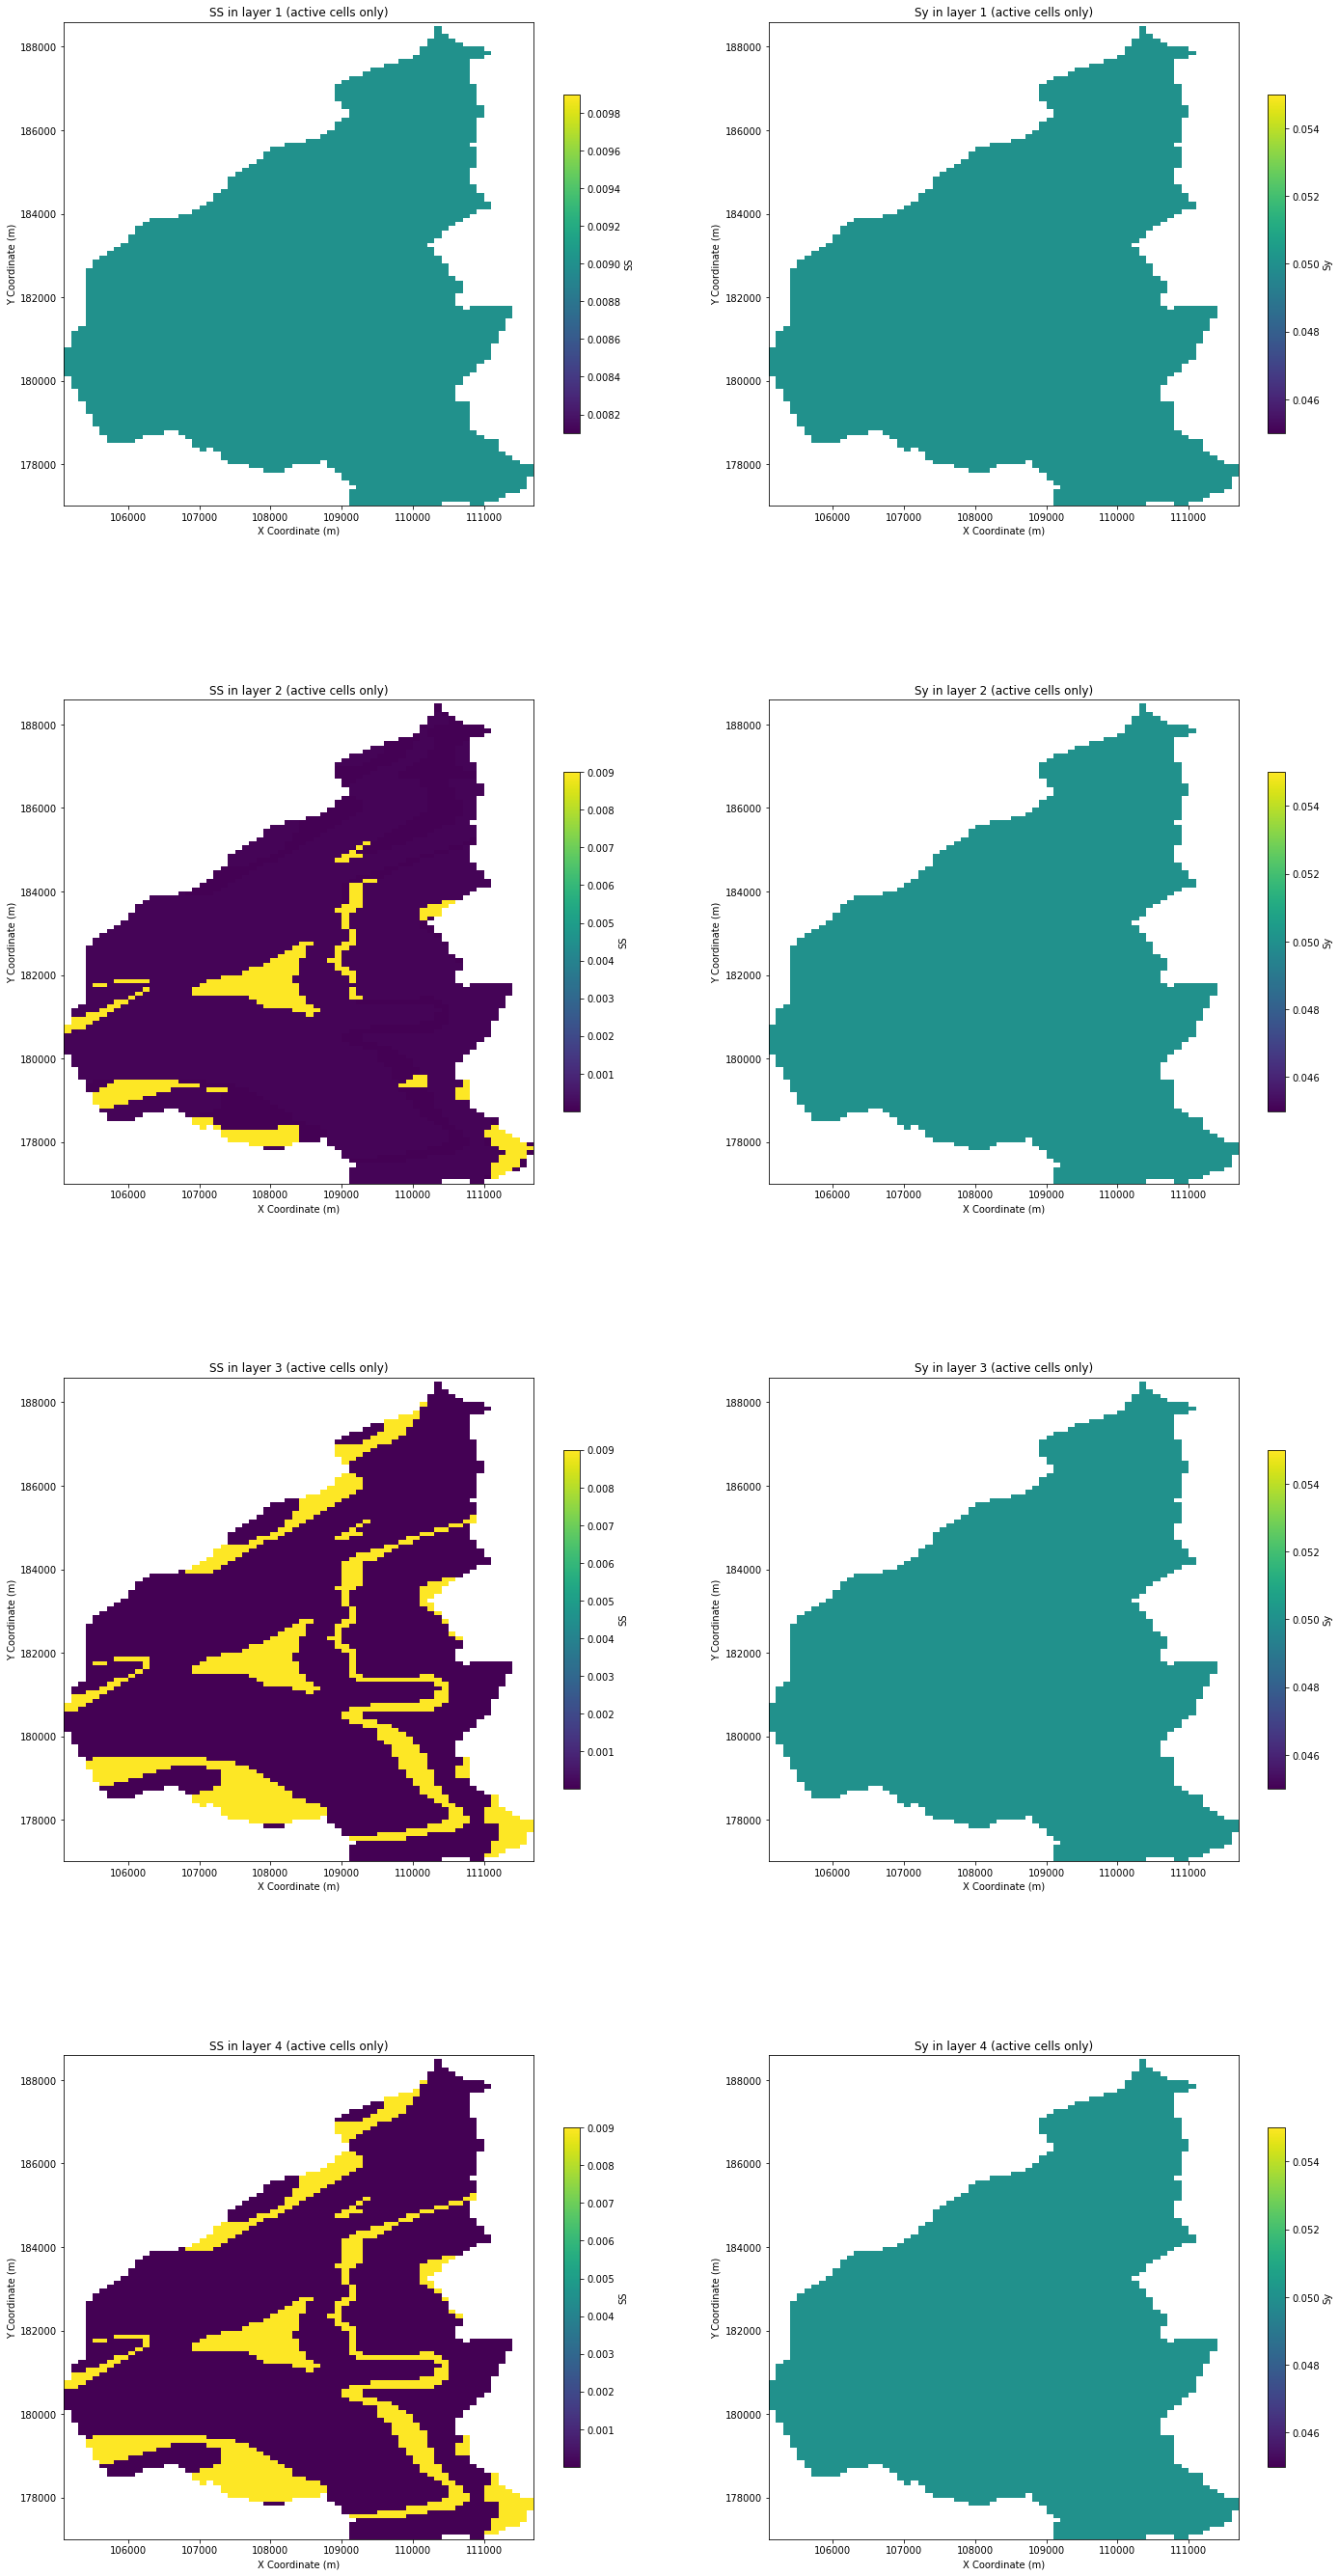

In [24]:
# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(24, 48))

for i in range(4):
    # Get the SS and Sy in layer i
    ss_layer = gwf.sto.ss.array[i]
    sy_layer = gwf.sto.sy.array[i]

    # Get the active cells in layer i 
    ibound_layer = gwf.dis.idomain.array[i]
    active_cells = ibound_layer > 0

    # Mask the 'ss' and 'sy' arrays with the active cells
    ss_layer_active = np.where(active_cells, ss_layer, np.nan)
    sy_layer_active = np.where(active_cells, sy_layer, np.nan)

    # Create a map of the model
    modelmap_ss = flopy.plot.PlotMapView(model=gwf, ax=axs[i, 0])
    modelmap_sy = flopy.plot.PlotMapView(model=gwf, ax=axs[i, 1])

    # Plot the 'ss' and 'sy' values of the active cells in layer i
    quadmesh_ss = modelmap_ss.plot_array(ss_layer_active, cmap='viridis')
    quadmesh_sy = modelmap_sy.plot_array(sy_layer_active, cmap='viridis')

    # Add a colorbar with a label
    cbar_ss = plt.colorbar(quadmesh_ss, shrink=0.7, ax=axs[i, 0])
    cbar_sy = plt.colorbar(quadmesh_sy, shrink=0.7, ax=axs[i, 1])
    cbar_ss.set_label('SS')
    cbar_sy.set_label('Sy')

    # Add labels to the x and y axes
    axs[i, 0].set_xlabel('X Coordinate (m)')
    axs[i, 0].set_ylabel('Y Coordinate (m)')
    axs[i, 1].set_xlabel('X Coordinate (m)')
    axs[i, 1].set_ylabel('Y Coordinate (m)')

    # Add a title
    axs[i, 0].set_title(f"SS in layer {i+1} (active cells only)")
    axs[i, 1].set_title(f"Sy in layer {i+1} (active cells only)")

# Adjust the space between the subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)

# Save the plot as a PNG file
plt.savefig('SS_Sy_all_layers.png')

# Show the plot
plt.show()

Load Recharge from SWAT+

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd
import flopy

# Load the recharge series CSV file
recharge_series = pd.read_csv('C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Inputs/Recharge/recharge_series.csv')

# Load the recharge zones shapefile
recharge_zones = gpd.read_file('C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Inputs/Recharge/recharge_zones.shp')

# Get the updated number of stress periods
nper = sim.tdis.nper.data

# Create a 3D array with the recharge rate for each aquifer feature at each time step
# Initialize all cells with a recharge of 0
recharge_array = np.zeros((nper, gwf.dis.nrow.data, gwf.dis.ncol.data))

# Map 'Aquifer' values to recharge rates
recharge_dict = recharge_series.set_index('name')['rchrg'].to_dict()

# Loop over each row in the recharge zones GeoDataFrame
for _, row in recharge_zones.iterrows():
    # Get the recharge series for the current aquifer feature
    rchrg = recharge_series.loc[recharge_series['name'] == row['Aquifer'], 'rchrg'].values

    # Assign the recharge series to the correct cell
    for kper in range(nper):
        recharge_array[kper, int(row['row_left']), int(row['col_left'])] = rchrg[kper]

# Create the recharge package
rch = flopy.mf6.ModflowGwfrcha(gwf, pname='rch')

# Set the recharge data for each stress period
for kper in range(nper):
    rch.recharge.set_data(recharge_array[kper], key=kper)

# Write the package
rch.write()

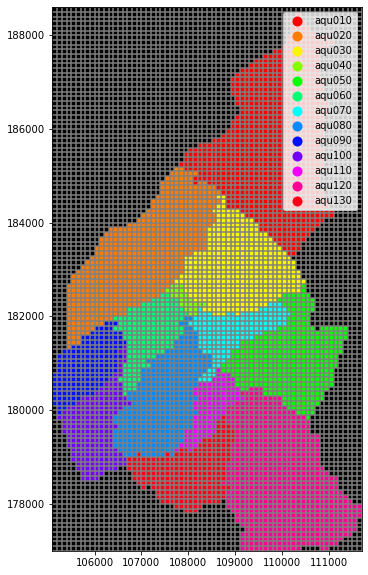

In [26]:
import matplotlib.pyplot as plt
from flopy.plot import PlotMapView

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Create a PlotMapView object
modelmap = PlotMapView(model=gwf, ax=ax)

# Plot the model grid
grid = modelmap.plot_grid()

# Plot the active cells
ibound = modelmap.plot_ibound()

# Plot the recharge zones with different colors for each aquifer
recharge_zones.plot(column='Aquifer', ax=ax, legend=True, cmap='hsv')

# Show the plot
plt.show()

### River data

In [27]:
#First: Clip river shapefile (WLas):

river_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Streams\\Shapefile"
shp_river = os.path.join(river_path,"Wlas.shp")


# Load your polygon and line shapefiles
polygon = gpd.read_file(shp_Gondebeek_path)
line = gpd.read_file(shp_river)

# Reproject the line GeoDataFrame to match the CRS of the polygon GeoDataFrame
line = line.to_crs(polygon.crs)

# Perform the clip operation
clipped = gpd.clip(line, polygon)

shp_river_clipped = os.path.join(river_path,"Wlas_clipped.shp")
# Save the clipped part to a new shapefile
clipped.to_file(shp_river_clipped)

In [28]:
from rtree import index
import geopandas as gpd
from shapely.geometry import Polygon

# Get the groundwater flow model
gwf = sim.get_model("Gondebeek")  # Replace "Gondebeek_SS" with the name of your model

# Get the top elevation array and active cell data from your model
top_elev = gwf.dis.top.array
ibound = gwf.dis.idomain.array  # get the array of active cells

clipped = gpd.read_file(shp_river_clipped)
layer = 0  # layer number (only layer 1)
# Create a spatial index
idx = index.Index()

# Populate spatial index with bounding boxes of active cells
for row in range(gwf.modelgrid.nrow):
    for col in range(gwf.modelgrid.ncol):
        if ibound[layer, row, col] > 0:
            x_center = gwf.modelgrid.xcellcenters[row, col]
            y_center = gwf.modelgrid.ycellcenters[row, col]
            dx = gwf.modelgrid.delc[row] / 2
            dy = gwf.modelgrid.delr[col] / 2
            bounds = (x_center - dx, y_center - dy, x_center + dx, y_center + dy)
            idx.insert((row * gwf.modelgrid.ncol) + col, bounds)
            

# Initialize the segment and reach numbers
segment = 1
reach = 1
flow = 1

# Convert the shapefile to a list of [layer, row, column, segment, reach, flow, strhc1, strtop, slope, strthick, width, rough] for each reach
stream_data = []
processed_cells = set()  # Set to keep track of processed cells

for index, data in clipped.iterrows():
    # Get the vertices of the LineString
    vertices = list(data['geometry'].coords)
    
    for i in range(len(vertices) - 1):
        # Calculate the minimum and maximum x and y coordinates
        minx = min(vertices[i][0], vertices[i+1][0])
        miny = min(vertices[i][1], vertices[i+1][1])
        maxx = max(vertices[i][0], vertices[i+1][0])
        maxy = max(vertices[i][1], vertices[i+1][1])
        
        # Get intersecting cells using spatial index
        coordinates = (minx, miny, maxx, maxy)
        intersecting_cells = list(idx.intersection(coordinates))
       
        if not intersecting_cells:
            continue
        
        # Process only the intersecting active cells
        for cell_index in intersecting_cells:
            row = cell_index // gwf.modelgrid.ncol
            col = cell_index % gwf.modelgrid.ncol
            
            # Skip the specific cells
            if (row, col) in [(1, 52), (6, 58)]:
                continue
            
            # Skip if the cell has already been processed
            if (row, col) in processed_cells:
                continue
            
            layer = 0  # layer number (only layer 1)
            # Check if the cell is within the active domain
            if ibound[layer, row, col] > 0:
                
                # Calculate the reach length as the distance between the centers of the cells
                next_row, next_col = gwf.modelgrid.intersect(vertices[i+1][0], vertices[i+1][1])
                # Check if the next cell is within the active domain
                if ibound[layer, next_row, next_col] > 0:
                    rchlen = ((gwf.modelgrid.xcellcenters[row, col] - gwf.modelgrid.xcellcenters[next_row, next_col])**2 + 
                              (gwf.modelgrid.ycellcenters[row, col] - gwf.modelgrid.ycellcenters[next_row, next_col])**2)**0.5
                    strtop = top_elev[row, col]-1  # streambed top (top elevation of the cell - 1)
                    # Calculate the change in elevation
                    delta_elev = top_elev[row, col] - top_elev[next_row, next_col]
                    # Calculate the slope
                    slope = abs(delta_elev / rchlen)
                    if np.isnan(slope):
                        slope=0.018
                    strthick = 1.0  # streambed thickness
                    strhc1 = 43.0  # streambed conductance
                    stage = 1.0  # initial stream stage
                    width = 1.0  # stream width
                    rough = 1.0  # roughness coefficient
                    cell_id = (layer, row, col)
                    stream_data.append([cell_id, stage+strtop,strhc1,strtop])
                    reach += 1  # increment the reach number
                    processed_cells.add((row, col))  # Add the cell to the set of processed cells
                    
    segment += 1  # increment the segment number
    reach = 1  # reset the reach number for the next segment

# Get the number of stress periods
nstress = sim.tdis.nper.data

# Initialize the stress period data
stress_period_data = []

# Iterate over the stream data
for i in range(len(stream_data)):
    # Get the reach number
    reach = stream_data[i][0]
    
    # Add the reach to the stress period data with status and 'active' keyword
    stress_period_data.append((reach, 'status', 'active'))

# Convert the list to a dictionary
stress_period_data = {0: stress_period_data}
# Initialize the connection data
# Initialize the connection data
# Initialize the connection data
connection_data = []

# Iterate over the stream data
for i in range(len(stream_data) - 1):
    # Get the reach number and the number of the next reach
    reach = stream_data[i][0]
    next_reach = stream_data[i+1][0] if i+1 < len(stream_data) else None

    # Add the connection to the connection data
    if next_reach is not None:
        connection_data.append({"ifno": [reach], "ic": [next_reach]})
    else:
        connection_data.append({"ifno": [reach], "ic": [0]})

# Path to the source model
source_model_dir = "C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_it8"

# Load the source model
source_sim = MFSimulation.load(sim_name='Gondebeek_SS', sim_ws=source_model_dir, exe_name='mf6')
source_gwf = source_sim.get_model('Gondebeek_SS')

# Get the river package from the source model
source_riv = source_gwf.get_package("RIV")

# Get the DataFrame for the first stress period
source_conductance_df_0 = source_riv.stress_period_data.get_dataframe()[0]

# Get the conductance for the first cell
source_conductance = source_conductance_df_0['cond'].iloc[0]

# Update the conductance in the current model
for i in range(len(stream_data)):
    # Update the conductance
    stream_data[i][2] = source_conductance

# Get the number of stress periods
nstress = sim.tdis.nper.data

# Initialize the stress period data
stress_period_data = {}

# Copy the river data to all stress periods
for per in range(nstress):
    stress_period_data[per] = stream_data.copy()

# Add the updated stress period data to the SFR package
riv = ModflowGwfriv(gwf, pname='riv', save_flows=True, stress_period_data=stress_period_data)
riv.write()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 762 based on size of stress_period_data


Plot river

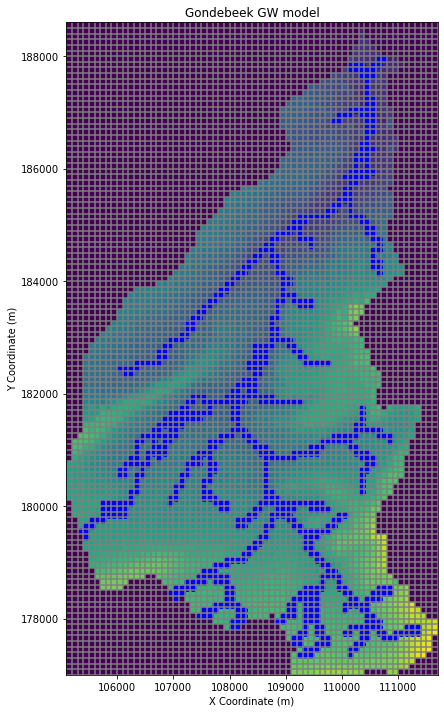

In [29]:
# Load the clipped river shapefile
clipped_river = gpd.read_file(shp_river_clipped)

# Get the top layer of the model
top_layer = gwf.dis.top.array

# Define the minimum and maximum values for the colorbar
vmin, vmax = 0, top_layer.max()

# Create a figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a map of the model
modelmap = flopy.plot.PlotMapView(model=gwf)


# Plot the top layer of the model
quadmesh = modelmap.plot_array(top_layer, vmin=vmin, vmax=vmax)

# Get the stream data from the RIV package
stream_data = gwf.riv.stress_period_data.get_data(kper=0)

# Plot the stream cells

for data in stream_data[0]:
    cellid = data['cellid']
    layer, row, col = cellid
    stage = data['stage']
    cond = data['cond']
    rbot = data['rbot']
    x = gwf.modelgrid.xcellcenters[row, col]
    y = gwf.modelgrid.ycellcenters[row, col]
    ax.plot(x, y, 'bo')  # 'bo' means blue circle

# Plot the grid lines
modelmap.plot_grid()

# Plot the clipped river shapefile first
clipped_river.plot(ax=ax, color='none', edgecolor='black')


# Add labels to the x and y axes
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')

# Add a title
plt.title("Gondebeek GW model")

# Save the plot as a PNG file
plt.savefig('Gondebeek_GW_model.png')

# Show the plot
plt.show()


Exporting to SHP

In [30]:
import geopandas as gpd
from shapely.geometry import Polygon


# Get the stream data from the RIV package for the first stress period
stream_data = gwf.riv.stress_period_data.get_data(kper=0)

# Create a list to store the polygons
polygons = []


# Loop through the stream data and create a Polygon for each stream cell
for data in stream_data[0]:
    cellid = data['cellid']
    layer, row, col = cellid
    stage = data['stage']
    cond = data['cond']
    rbot = data['rbot']
    x = gwf.modelgrid.xcellcenters[row, col]
    y = gwf.modelgrid.ycellcenters[row, col]
    dx = gwf.modelgrid.delc[row] / 2
    dy = gwf.modelgrid.delr[col] / 2
    polygons.append(Polygon([(x-dx, y-dy), (x-dx, y+dy), (x+dx, y+dy), (x+dx, y-dy)]))

# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the CRS of the GeoDataFrame to Belgian Lambert 72
gdf.crs = 'EPSG:31370'

# Define the output path
output_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Streams\Shapefile\river_cells.shp"

# Export the GeoDataFrame as a shapefile
gdf.to_file(output_path)


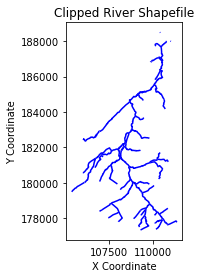

In [31]:
clipped_river = gpd.read_file(shp_river_clipped)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the shapefile
clipped_river.plot(ax=ax, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Clipped River Shapefile')

# Show the plot
plt.show()

Drain

In [32]:
# Get the top elevations and idomain from the discretization package
top = gwf.dis.top.array
idomain = gwf.dis.idomain.array

# Create a list to store the drain cells
drn_cells = []

# Convert processed_cells to a set for faster lookup
river_cells = set(processed_cells)

# Iterate over the cells in layer 1
for i in range(idomain.shape[1]):
    for j in range(idomain.shape[2]):
        # Only consider active cells that are not river cells
        if idomain[0, i, j] == 1 and (i, j) not in river_cells:
            # Calculate the drain elevation
            drn_elev = top[i, j] - 1

            # Add the cell to the list of drain cells
            drn_cells.append([(0, i, j), drn_elev, 10])

# Path to the source model
source_model_dir = "C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_it8"

# Load the source model
source_sim = MFSimulation.load(sim_name='Gondebeek_SS', sim_ws=source_model_dir, exe_name='mf6')
source_gwf = source_sim.get_model('Gondebeek_SS')

# Get the Drain package from the source model
source_drn = source_gwf.get_package("DRN")

# Get the DataFrame for the first stress period
source_conductance_df_0 = source_drn.stress_period_data.get_dataframe()[0]

# Get the conductance for the first cell
source_conductance = source_conductance_df_0['cond'].iloc[0]


# Update the conductance in the current model
for i in range(len(drn_cells)):
    # Update the conductance
    drn_cells[i][2] = source_conductance

# Get the number of stress periods
nstress = sim.tdis.nper.data

# Initialize the stress period data
stress_period_data = {}

# Copy the drain data to all stress periods
for per in range(nstress):
    stress_period_data[per] = drn_cells.copy()

# Create the Drain package
drn = flopy.mf6.ModflowGwfdrn(gwf, save_flows=True, pname='drn', stress_period_data=stress_period_data)
drn.write()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 3585 based on size of stress_period_data


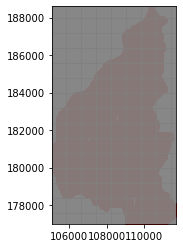

In [33]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Create a list to store the points
points = []

# Loop through the drain cells and create a Point for each cell
for cell in drn_cells:
    cellid = cell[0]
    layer, row, col = cellid
    x = gwf.modelgrid.xcellcenters[row, col]
    y = gwf.modelgrid.ycellcenters[row, col]
    points.append(Point(x, y))

# Create a GeoDataFrame from the points
drn_gdf = gpd.GeoDataFrame(geometry=points)

# Set the CRS of the GeoDataFrame to Belgian Lambert 72
drn_gdf.crs = 'EPSG:31370'

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the model grid
gwf.modelgrid.plot(ax=ax)

# Plot the drain cells
drn_gdf.plot(ax=ax, color='red')

# Show the plot
plt.show()

In [34]:
sim.write_simulation()
update_maxats('Gondebeek.tdis.ats', nper)
#sim.check()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package Gondebeek.ats...
  writing package Gondebeek.tdis.ats...
  writing model Gondebeek...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package rch...
    writing package riv...
    writing package drn...


In [35]:

# Run the model
sim.run_simulation()

FloPy is using the following executable to run the model: mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held l

(True, [])

## Results

Check heads after running

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek...


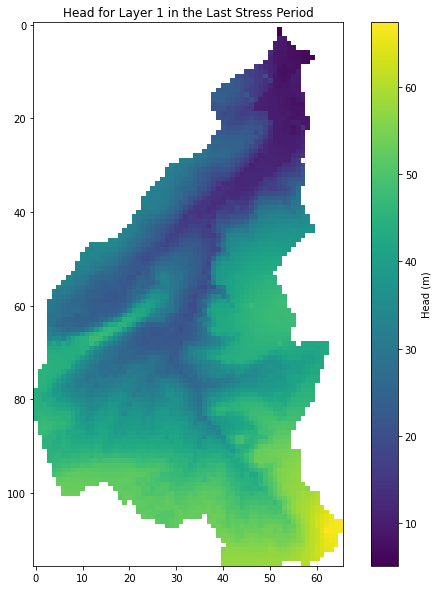

In [2]:
# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Check if 'sim' and 'gwf' are already defined
if 'sim' not in globals() or 'gwf' not in globals():
    # Load the model
    sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek')
    gwf = sim.get_model('Gondebeek')

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Get the idomain array from the DIS package
idomain = gwf.dis.idomain.array

# Create a mask for the active cells
mask = (idomain != 1)

# Apply the mask to the head array
head = np.ma.masked_where(mask, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[0, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()



In [3]:
times[0]

1.0

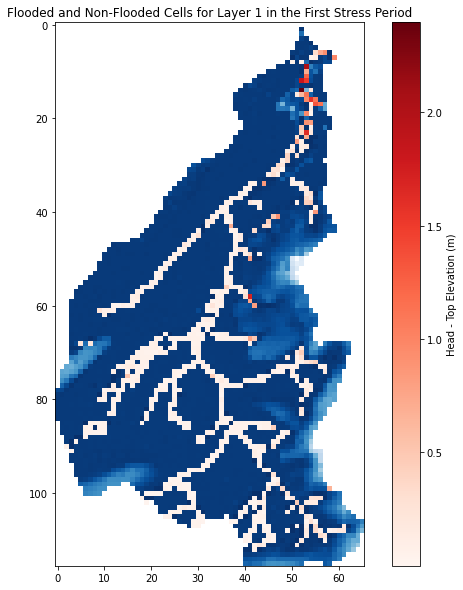

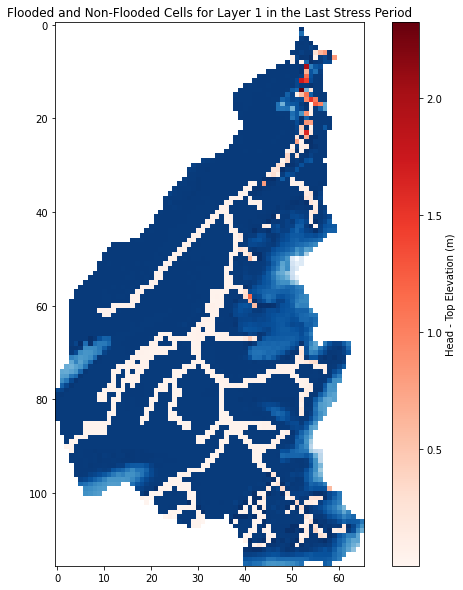

In [4]:


# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Get all the time steps
times = hds.get_times()

# Get the head for the first time step
head_first = hds.get_data(totim=times[0])

# Calculate the difference between the head and the top elevation for the first stress period
diff_first = head_first[0, :, :] - gwf.dis.top.array

# Mask very high and very low values
diff_first = np.ma.masked_outside(diff_first, -1e6, 1e6)

# Create a mask for the flooded cells (where the difference is positive) for the first stress period
flooded_first = np.ma.masked_where(diff_first <= 0, diff_first)

# Create a mask for the non-flooded cells (where the difference is zero or negative) for the first stress period
non_flooded_first = np.ma.masked_where(diff_first > 0, diff_first)

# Plot the non-flooded cells in blue and the flooded cells in red for the first stress period
plt.figure(figsize=(10, 10))
plt.imshow(non_flooded_first, cmap='Blues', interpolation='none')
plt.imshow(flooded_first, cmap='Reds', interpolation='none')
plt.colorbar(label='Head - Top Elevation (m)')
plt.title('Flooded and Non-Flooded Cells for Layer 1 in the First Stress Period')
plt.show()

# Get the head for the last time step
head_last = hds.get_data(totim=times[-1])

# Calculate the difference between the head and the top elevation for the last stress period
diff_last = head_last[0, :, :] - gwf.dis.top.array

# Mask very high and very low values
diff_last = np.ma.masked_outside(diff_last, -1e6, 1e6)

# Create a mask for the flooded cells (where the difference is positive) for the last stress period
flooded_last = np.ma.masked_where(diff_last <= 0, diff_last)

# Create a mask for the non-flooded cells (where the difference is zero or negative) for the last stress period
non_flooded_last = np.ma.masked_where(diff_last > 0, diff_last)

# Plot the non-flooded cells in blue and the flooded cells in red for the last stress period
plt.figure(figsize=(10, 10))
plt.imshow(non_flooded_last, cmap='Blues', interpolation='none')
plt.imshow(flooded_last, cmap='Reds', interpolation='none')
plt.colorbar(label='Head - Top Elevation (m)')
plt.title('Flooded and Non-Flooded Cells for Layer 1 in the Last Stress Period')
plt.show()

hds.close()

In [5]:
head_last.shape

(4, 116, 66)

In [6]:

directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow'
# Get the idomain array from the dis package of the model
idomain = gwf.dis.idomain.array

# Create the zone array from the idomain array
zon = np.where(idomain == 0, 1, idomain)

zonbud = gwf.output.zonebudget(zon)
zonbud.change_model_ws(directory)
zonbud.write_input()
zonbud.run_model()

df = zonbud.get_dataframes(net=True)
df = df.reset_index()

# Delete the zonbud object
del zonbud

# Print the contents of the CSV file for the last time step and stress period
print(df)
print(df['name'],df['ZONE_1']/86.4)

FloPy is using the following executable to run the model: zbud6.exe
                              ZONEBUDGET Version 6
                             U.S. GEOLOGICAL SURVEY
                            VERSION 6.4.4 02/13/2024
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

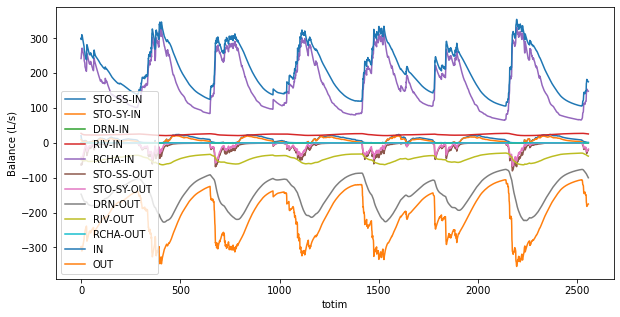

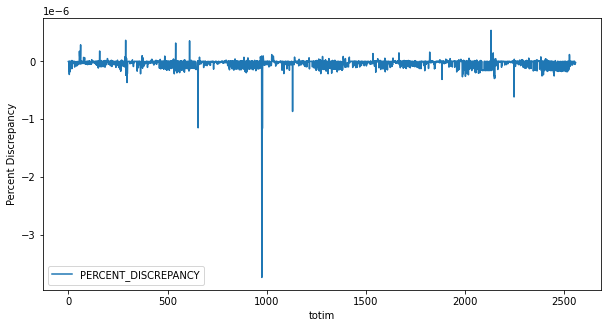

In [7]:
# Load the budget data from the CSV file
budget_df = pd.read_csv('zonebud.csv')

# Make all '-OUT' values negative
for column in budget_df.columns:
    if column.endswith('-OUT'):
        budget_df[column] = -budget_df[column]

# Compute the total inflow and outflow for each time step
budget_df['IN'] = budget_df.filter(regex='-IN$').sum(axis=1)
budget_df['OUT'] = budget_df.filter(regex='-OUT$').sum(axis=1)

# Compute the percent discrepancy
budget_df['PERCENT_DISCREPANCY'] = (budget_df['OUT'] + budget_df['IN']) / budget_df['IN'] * 100

# Select only the "-IN" and "-OUT" terms
budget_df = budget_df.filter(regex='IN$|OUT$|PERCENT_DISCREPANCY')

# Convert the flow values from cubic meters per day to liters per second, excluding the percent discrepancy
for component in budget_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        budget_df[component] = pd.to_numeric(budget_df[component], errors='coerce') / 86.4

# Plot each component of the balances, excluding the "percent discrepancy"
plt.figure(figsize=(10, 5))
for component in budget_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        if len(budget_df.index) == 1:
            plt.scatter(budget_df.index.to_numpy(), budget_df[component].to_numpy(), label=component)
        else:
            plt.plot(budget_df.index.to_numpy(), budget_df[component].to_numpy(), label=component)

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Balance (L/s)')  # Update the y-axis label

# Show the plot
plt.show()

# Show the plot
plt.show()

# Plot the "percent discrepancy" separately
plt.figure(figsize=(10, 5))
if len(budget_df.index) == 1:
    plt.scatter(budget_df.index.to_numpy(), budget_df['PERCENT_DISCREPANCY'].to_numpy(), label='PERCENT_DISCREPANCY')
else:
    plt.plot(budget_df.index.to_numpy(), budget_df['PERCENT_DISCREPANCY'].to_numpy(), label='PERCENT_DISCREPANCY')

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Percent Discrepancy')

# Show the plot
plt.show()

Compute the base flow for further analysis

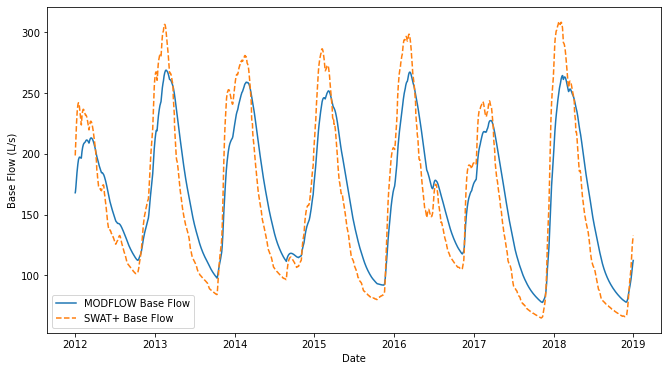

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the base flow from SWAT+
swat_base_flow = pd.read_csv('C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Recharge\\daily_flow.csv')

# Convert the 'date' column to datetime
swat_base_flow['date'] = pd.to_datetime(swat_base_flow['date'])

# Compute the base flow using absolute values
budget_df['BASE_FLOW'] = budget_df['DRN-OUT'].abs() + budget_df['RIV-OUT'].abs() - budget_df['RIV-IN'].abs()

# Take the absolute value of the result
budget_df['BASE_FLOW'] = budget_df['BASE_FLOW'].abs()

# Save the base flow to a CSV file
budget_df['BASE_FLOW'].to_csv('base_flow.csv', index=False)

# Create a date range starting from '1-1-2012' and assign it to the DataFrame
start_date = pd.Timestamp('2012-01-01')
budget_df['date'] = pd.date_range(start=start_date, periods=len(budget_df), freq='D')

# Plot the base flow
plt.figure(figsize=(11, 6))
if len(budget_df.index) == 1:
    plt.scatter(budget_df['date'].dt.to_pydatetime(), budget_df['BASE_FLOW'].to_numpy(), label='MODFLOW Base Flow')
else:
    plt.plot(budget_df['date'].dt.to_pydatetime(), budget_df['BASE_FLOW'].to_numpy(), label='MODFLOW Base Flow')

# Plot the base flow from SWAT+
plt.plot(swat_base_flow['date'].dt.to_pydatetime(), swat_base_flow['flow_L_s'].to_numpy(), label='SWAT+ Base Flow', linestyle='--')

# Add a legend
plt.legend()

# Add labels
plt.xlabel('Date')
plt.ylabel('Base Flow (L/s)')

# Show the plot
plt.show()

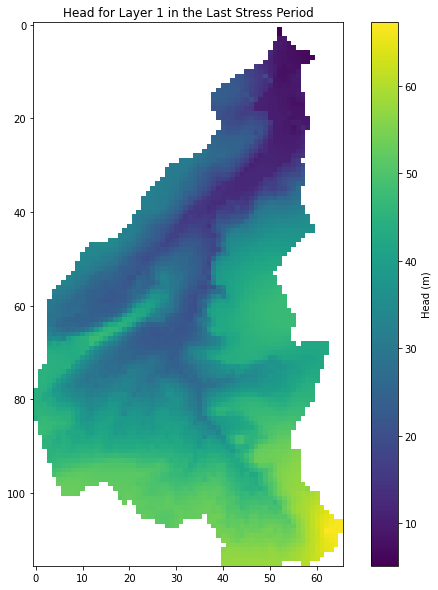

In [25]:
# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Get all the time steps
times = hds.get_times()

# Get the head for the last time step
head = hds.get_data(totim=times[-1])

# Load the idomain data
idomain = gwf.dis.idomain.array

# Mask inactive cells
head = np.ma.masked_where(idomain == 0, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()



In [26]:

# Get the modelgrid from the model
modelgrid = gwf.modelgrid

# Create a vtk object
vtkobj = flopy.export.vtk.Vtk(gwf, modelgrid=modelgrid, vertical_exageration=10,binary=False)

# Flatten the entire 3D array of bottom elevations
botm_flattened = gwf.dis.botm.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(botm_flattened, "botm")

# Calculate the top elevations
botm = gwf.dis.botm.array
top = np.empty_like(botm)
top[0] = gwf.dis.top.array
top[1:] = botm[:-1]

# Flatten the entire 3D array of top elevations
top_flattened = top.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(top_flattened, "top")

# Flatten the entire 3D array of hydraulic conductivity
hk_flattened = gwf.npf.k.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(hk_flattened, "k")

# Flatten the entire 3D array of specific storage
ss_flattened = gwf.sto.ss.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ss_flattened, "ss")

# Flatten the entire 3D array of specific yield
sy_flattened = gwf.sto.sy.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(sy_flattened, "sy")

# Flatten the entire 3D array of ibound
ibound_flattened = gwf.dis.idomain.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ibound_flattened, "ibound")

# Write the VTK object to a file
vtkobj.write("model.vtk")



In [27]:
# Set the backend for PyVista
pv.set_jupyter_backend('trame')

# Convert the VTK object to a PyVista mesh
mesh = vtkobj.to_pyvista()

# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

# List all available point data
print(thresholded_mesh)

# Plot the thresholded mesh with a specific property
# Replace 'property_name' with the name of the property you want to visualize
thresholded_mesh.plot(scalars='k', cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], show_edges=False)

# Save the thresholded mesh to a VTK file
thresholded_mesh.save("Gondebeek_act.vtk")

UnstructuredGrid (0x22cece91340)
  N Cells:    17388
  N Points:   139104
  X Bounds:   1.051e+05, 1.117e+05
  Y Bounds:   1.770e+05, 1.885e+05
  Z Bounds:   -2.823e+02, 7.844e+02
  N Arrays:   6


Widget(value='<iframe src="http://localhost:63941/index.html?ui=P_0x22cecdb5ac0_0&reconnect=auto" class="pyvis…

In [28]:
botm=gwf.dis.botm.array
mesh["botm"] = np.ravel(botm)
# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

thresholded_mesh.plot(cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], scalars="botm", show_edges=False)

Widget(value='<iframe src="http://localhost:63941/index.html?ui=P_0x22ce1bba880_1&reconnect=auto" class="pyvis…

Export heads to VTK

In [29]:
# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Get the head for the first, 1000th, and last time step
head_first = hds.get_data(totim=times[0])
head_mid = hds.get_data(totim=times[999])  # assuming 1000th time step exists
head_last = hds.get_data(totim=times[-1])

# Flatten the entire 3D array of head data
head_first_flattened = head_first.flatten()
head_mid_flattened = head_mid.flatten()
head_last_flattened = head_last.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(head_first_flattened, "head_first")
vtkobj.add_array(head_mid_flattened, "head_mid")
vtkobj.add_array(head_last_flattened, "head_last")

# Write the VTK object to a file
vtkobj.write("model_with_head.vtk")

# Convert the VTK object to a PyVista mesh
mesh = vtkobj.to_pyvista()

# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

# Plot the thresholded mesh with the head data
thresholded_mesh.plot(scalars='head_last', cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], show_edges=False)

# Save the thresholded mesh to a VTK file
thresholded_mesh.save("Gondebeek_act_with_head.vtk")

Widget(value='<iframe src="http://localhost:63941/index.html?ui=P_0x22cedc71d30_2&reconnect=auto" class="pyvis…

Load mf6mod2obs results

C:\Users\sebas\AppData\Local\Temp\ipykernel_3260\3094348071.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date = pd.to_datetime(fields[1])


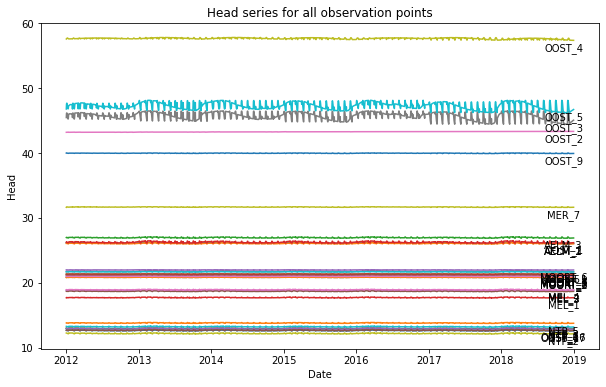

In [30]:

# Parse the output of the utility
data = []
with open("simulated.smp", "r") as f:  # replace "output.txt" with the actual output file
    for line in f:
        fields = line.split()
        obs_point = fields[0]
        date = pd.to_datetime(fields[1])
        head = float(fields[3])
        data.append((obs_point, date, head))

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=["obs_point", "date", "head"])

# Pivot the DataFrame to get one column per observation point
df_pivot = df.pivot(index="date", columns="obs_point", values="head")

# Plot the head series for all observation points
plt.figure(figsize=(10, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index.to_numpy(), df_pivot[column].to_numpy(), label=column)

    # Add a label over the line
    y_pos = df_pivot[column].iloc[-1]  # y position of the label (last value of the series)
    plt.annotate(column, (df_pivot.index[-1], y_pos), textcoords="offset points", xytext=(-10,-10), ha='center')

plt.xlabel("Date")
plt.ylabel("Head")
plt.title("Head series for all observation points")

# Save the plot as an image
plt.savefig("heads_transient_ats.png", dpi=300)

plt.show()